In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [2]:
import pandas as pd
import numpy as np
df = pd.read_csv('/content/drive/MyDrive/quora/train.csv')
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


## Removing Nan Values

In [3]:
imp = df[['question1','question2']]
imp[(imp.iloc[:,0].isnull()) | (imp.iloc[:,1].isnull())]

,question1,question2
105780,How can I develop android app?,NaN
201841,How can I create an Android app?,NaN
363362,NaN,My Chinese name is Haichao Yu. What English na...


In [4]:
df.drop(index=[105780,201841,363362],inplace=True)

## Preprocessing Data

In [5]:
q1 = df['question1']
q2 = df['question2']
y = df['is_duplicate']

In [6]:
def preprocess(df):
    return df.str.replace(r"""[!"#$%&'()*+,\-./:;<=>?@[\]^_`{|}~]""",r'',regex=True).str.lower()

q1 = preprocess(q1)
q2 = preprocess(q2)

In [7]:
all_word = list(q1) + list(q2)
from tensorflow.keras.preprocessing.text import Tokenizer
tokenize = Tokenizer()
tokenize.fit_on_texts(all_word)
len(tokenize.word_index)

111538

In [8]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [9]:
from nltk.tokenize import word_tokenize
tokenize_sent = [word_tokenize(sent) for sent in all_word]


## Training Word2Vec Model

In [10]:
import gensim
from gensim.models import Word2Vec,KeyedVectors

model = Word2Vec(window=10,min_count =2,vector_size =100)
model.build_vocab(tokenize_sent)


In [12]:
model.train(tokenize_sent,total_examples=model.corpus_count,epochs=20)

(126643476, 178835180)

## Creating Embedding matrix

In [14]:
vocab_size = len(tokenize.word_index)
emb_dim = model.vector_size
emb_matrix = np.zeros((vocab_size,emb_dim))

dic = tokenize.word_index
for word,val in dic.items():
    try :
        word_vec = model.wv[f'{word}']
    except:
        continue
    if word_vec is not None:
        emb_matrix[val] = word_vec

In [ ]:
emb_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.04107722, -0.90325308, -0.81035453, ..., -1.4768635 ,
        -1.0956887 ,  1.46329701],
       [ 0.97332007,  0.26848653, -0.15600407, ..., -3.01779151,
        -1.89036489,  0.57131171],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

## Tokenization and Padding

In [15]:
q1_token = tokenize.texts_to_sequences(list(q1))
q2_token = tokenize.texts_to_sequences(list(q2))

In [16]:
max_= 0
for sent in q1_token:
    if max_< len(sent):
        max_ = len(sent)
for sent in q2_token:
    if max_< len(sent):
        max_ = len(sent)
max_

237

In [20]:
from tensorflow.keras.utils import pad_sequences
q1_padded = pad_sequences(q1_token,maxlen=max_)
q2_padded = pad_sequences(q2_token,maxlen=max_)

q1_padded

array([[    0,     0,     0, ...,   372,     8,    35],
       [    0,     0,     0, ..., 11869, 11869,  4558],
       [    0,     0,     0, ...,   142,     6,  2772],
       ...,
       [    0,     0,     0, ...,     3,    49,  4324],
       [    0,     0,     0, ...,    32,    81,   229],
       [    0,     0,     0, ...,   150,    29,  4646]], dtype=int32)

In [21]:
q2_padded.shape

(404287, 237)

## Feature Engineering

In [41]:
def common_word(row):
  w1 = set(map(lambda word:word.lower().strip(),row['question1'].split(" ")))
  w2 = set(map(lambda word:word.lower().strip(),row['question2'].split(" ")))
  return len(w1 & w2)

common_unique_words = df.apply(common_word,axis=1)

In [42]:
common_unique_words.head()

0    10
1     4
2     4
3     0
4     2
dtype: int64

## Non Linear Model 

In [43]:
from tensorflow.keras.layers import Dense,Input,Embedding,LSTM,concatenate,BatchNormalization,Dropout
from keras.models import Model

In [45]:
input_DIM = (q1_padded.shape[1],)
input1 = Input(shape = input_DIM)
input2 = Input(shape=input_DIM)

Emb1 = Embedding(input_dim=emb_matrix.shape[0],output_dim=emb_matrix.shape[1],input_length = max_,weights=[emb_matrix])(input1)
Emb2 = Embedding(input_dim=emb_matrix.shape[0],output_dim=emb_matrix.shape[1],input_length = max_,weights=[emb_matrix])(input2)

LSTM1 = LSTM(150)(Emb1)
LSTM2 = LSTM(150)(Emb2)

##Common words
input_common = Input(shape=(1,))

c_dense = Dense(150,activation='relu')(input_common)


combine = concatenate([LSTM1,LSTM2,c_dense])

norm = BatchNormalization()(combine)
drop = Dropout(0.5)(norm)

d1 = Dense(150,activation='relu')(drop)

norm2 = BatchNormalization()(d1)
drop2 = Dropout(0.5)(norm2)

##ANN

hidden1 = Dense(150,activation='relu')(drop2)
hidden2 = Dense(150,activation='relu')(hidden1)

output = Dense(1,activation='sigmoid')(hidden2)

model_final = Model(inputs=[input1,input2,input_common],outputs=output)
model_final.summary()

model_final.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 237)]                0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 237)]                0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 237, 100)             1115380   ['input_4[0][0]']             
                                                          0                                       
                                                                                                  
 embedding_3 (Embedding)     (None, 237, 100)             1115380   ['input_5[0][0]']       

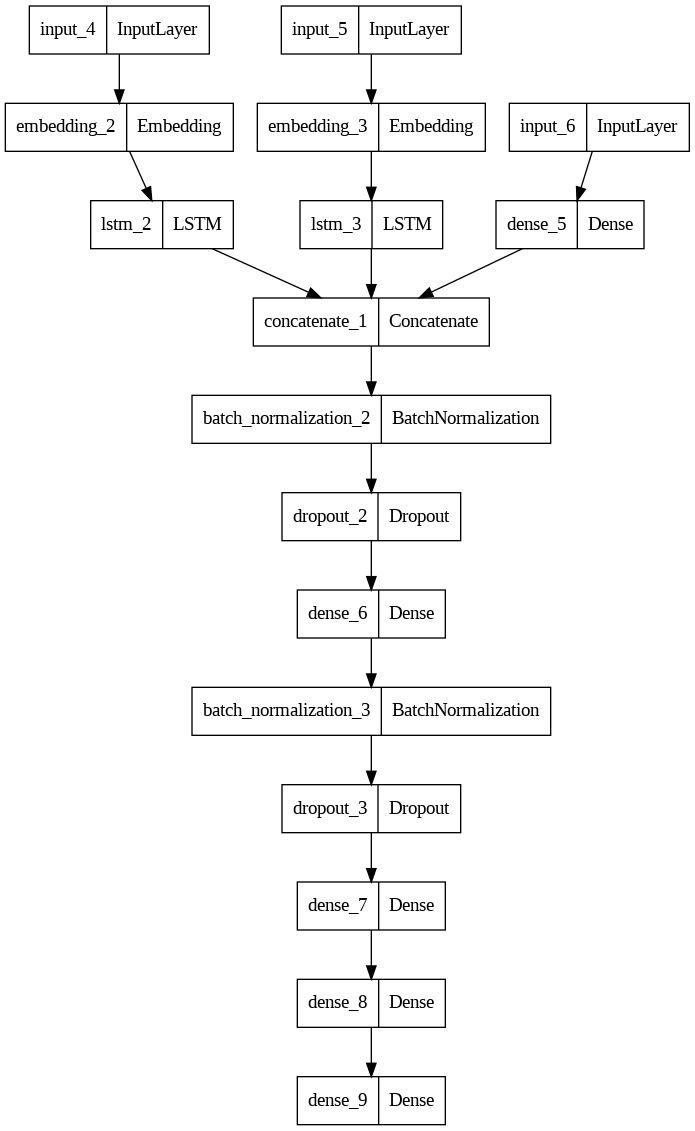

In [46]:
from keras.utils import plot_model
plot_model(model_final)

In [50]:
from sklearn.model_selection import train_test_split
X1_train, X1_val, X2_train, X2_val,X3_train, X3_val, y_train, y_val = train_test_split(
    q1_padded, q2_padded,common_unique_words ,y, test_size=0.2, random_state=42
)

In [56]:
##training Model
history = model_final.fit([X1_train,X2_train,X3_train],y_train,validation_data=([X1_val,X2_val,X3_val],y_val),epochs=10,batch_size=1024)

Epoch 1/10
316/316 [==============================] - 110s 320ms/step - loss: 0.4813 - accuracy: 0.7455 - val_loss: 0.4467 - val_accuracy: 0.7639
Epoch 2/10
316/316 [==============================] - 95s 300ms/step - loss: 0.4296 - accuracy: 0.7812 - val_loss: 0.4050 - val_accuracy: 0.7948
Epoch 3/10
316/316 [==============================] - 93s 296ms/step - loss: 0.4010 - accuracy: 0.7994 - val_loss: 0.3928 - val_accuracy: 0.8038
Epoch 4/10
316/316 [==============================] - 93s 296ms/step - loss: 0.3812 - accuracy: 0.8129 - val_loss: 0.3821 - val_accuracy: 0.8104
Epoch 5/10
316/316 [==============================] - 88s 279ms/step - loss: 0.3598 - accuracy: 0.8264 - val_loss: 0.3852 - val_accuracy: 0.8101
Epoch 6/10
316/316 [==============================] - 93s 294ms/step - loss: 0.3336 - accuracy: 0.8421 - val_loss: 0.3772 - val_accuracy: 0.8187
Epoch 7/10
316/316 [==============================] - 88s 280ms/step - loss: 0.3061 - accuracy: 0.8580 - val_loss: 0.3769 - val_a

## Result

In [58]:
from sklearn.metrics import accuracy_score
y_log = model_final.predict([X1_val,X2_val,X3_val])
y_pred = np.where(y_log > 0.5,1,0)

print(accuracy_score(y_true = y_val,y_pred = y_pred))

2527/2527 [==============================] - 24s 9ms/step
0.8221078928491924


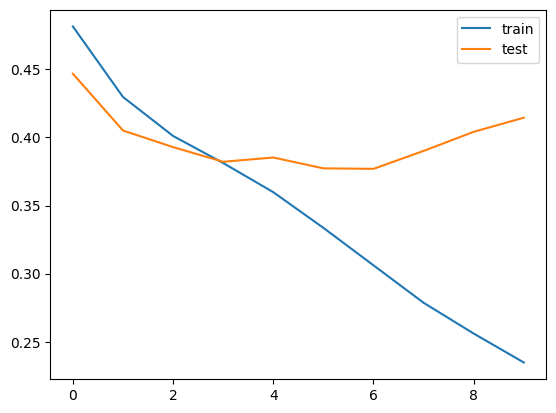

In [59]:
d = history.history

import matplotlib.pyplot as plt
plt.plot(d['loss'],label='train')
plt.plot(d['val_loss'],label='test')
plt.legend()

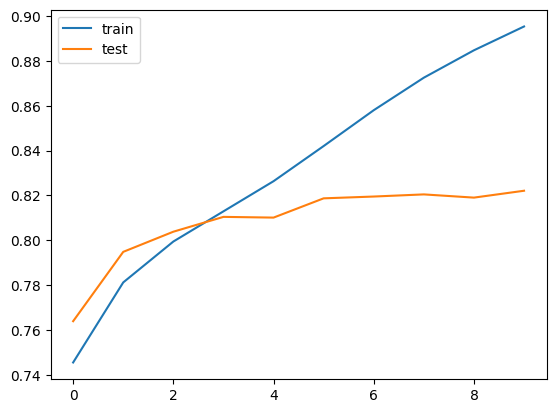

In [61]:
plt.plot(d['accuracy'],label='train')
plt.plot(d['val_accuracy'],label='test')
plt.legend()

## Using Pretrained Word2vec Model

In [ ]:
import gensim.downloader

In [ ]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [ ]:
word2vec_vectors = gensim.downloader.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
dic = tokenize.word_index


In [ ]:
vocab_size = len(tokenize.word_index)
emb_matrix = np.zeros((vocab_size+1,300))
for word,val in dic.items():
    try :
        word_vec = word2vec_vectors[f'{word}']
    except:
        continue
    if word_vec is not None:
        emb_matrix[val] = word_vec

In [ ]:
emb_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.08007812,  0.10498047,  0.04980469, ...,  0.00366211,
         0.04760742, -0.06884766],
       [ 0.13964844, -0.00616455,  0.21484375, ...,  0.05712891,
         0.09960938, -0.234375  ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.10498047,  0.23535156,  0.08935547, ..., -0.08691406,
         0.12451172, -0.12304688]])

In [ ]:

input_DIM = (q1_padded.shape[1],)
input1 = Input(shape = input_DIM)
input2 = Input(shape=input_DIM)

Emb1 = Embedding(input_dim=emb_matrix.shape[0],output_dim=emb_matrix.shape[1],input_length = max_,weights=[emb_matrix])(input1)
Emb2 = Embedding(input_dim=emb_matrix.shape[0],output_dim=emb_matrix.shape[1],input_length = max_,weights=[emb_matrix])(input2)

LSTM1 = LSTM(150)(Emb1)
LSTM2 = LSTM(150)(Emb2)

combine = concatenate([LSTM1,LSTM2])

norm = BatchNormalization()(combine)
drop = Dropout(0.5)(norm)

d1 = Dense(150,activation='relu')(drop)

norm2 = BatchNormalization()(d1)
drop2 = Dropout(0.5)(norm2)

##ANN

hidden1 = Dense(150,activation='relu')(drop2)
hidden2 = Dense(150,activation='relu')(hidden1)

output = Dense(1,activation='sigmoid')(hidden2)

model_final = Model(inputs=[input1,input2],outputs=output)
model_final.summary()

model_final.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 237)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 237)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 237, 300)             3346170   ['input_1[0][0]']             
                                                          0                                       
                                                                                                  
 embedding_1 (Embedding)     (None, 237, 300)             3346170   ['input_2[0][0]']         

In [ ]:
history = model_final.fit([X1_train,X2_train],y_train,validation_data=([X1_val,X2_val],y_val),epochs=10,batch_size=1024)

Epoch 1/10
316/316 [==============================] - 165s 489ms/step - loss: 0.5352 - accuracy: 0.7297 - val_loss: 0.5290 - val_accuracy: 0.7609
Epoch 2/10
316/316 [==============================] - 140s 442ms/step - loss: 0.4499 - accuracy: 0.7860 - val_loss: 0.4659 - val_accuracy: 0.7675
Epoch 3/10
316/316 [==============================] - 142s 450ms/step - loss: 0.3934 - accuracy: 0.8173 - val_loss: 0.4589 - val_accuracy: 0.7826
Epoch 4/10
316/316 [==============================] - 142s 450ms/step - loss: 0.3424 - accuracy: 0.8436 - val_loss: 0.4831 - val_accuracy: 0.7812
Epoch 5/10
316/316 [==============================] - 142s 451ms/step - loss: 0.2975 - accuracy: 0.8659 - val_loss: 0.5107 - val_accuracy: 0.7757
Epoch 6/10
316/316 [==============================] - 142s 450ms/step - loss: 0.2621 - accuracy: 0.8835 - val_loss: 0.5338 - val_accuracy: 0.7802
Epoch 7/10
316/316 [==============================] - 140s 444ms/step - loss: 0.2339 - accuracy: 0.8968 - val_loss: 0.6270 -

In [ ]:
from sklearn.metrics import accuracy_score
y_log = model_final.predict([X1_val,X2_val])
y_pred = np.where(y_log > 0.5,1,0)

print(accuracy_score(y_true = y_val,y_pred = y_pred))

2527/2527 [==============================] - 26s 10ms/step
0.7793291943901655


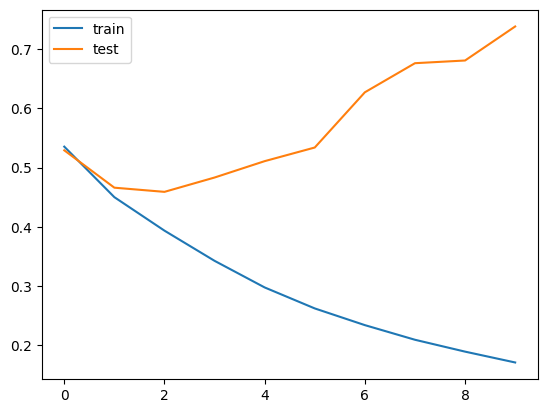

In [ ]:
d = history.history

import matplotlib.pyplot as plt
plt.plot(d['loss'],label='train')
plt.plot(d['val_loss'],label='test')
plt.legend()